### Plot Selected Features by Survival Outcomes

In this notebook we plot survival outcome (event/censored) and survival time for selected features. We examine:
- `age_at_hct`
- `comorbidity_score`
- `karnofsky_score`
- `hla_match_drb1_high`
- `hla_high_res_10`
- `race_group`

The first four features were identified as imortant via experiments with lasso regression. The feature `hla_high_res_10` is an overall measure of genetic compatibility of donor vs. recipient. Since one HLA match feature was identified as important, it seems reasonable to consider overall HLA match. Finall, race is relevant to our metric (risk score, stratified by race). The feature `hla_match_drb1_low`, which was also flagged as important, is not included. That feature is a less-sensitive measure of the same allele match as `hla_match_drb1_low`.

#### Load Data

In [3]:
# Import libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
df = pd.read_csv("../data/train_set.csv")
df['efs'] = df['efs'].replace({0:"Censored", 1:"Event"})

In [5]:
print("The training set has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The training set has 23040 rows and 60 columns


#### Define Helper Functions to Plot Features

In [6]:
# Function that takes the name of 
# and produces a histogram of the number of 
# cases for each value of the feature, 
# broken down by efs (Event/Censored).

def hist_by_efs(feat_name, df=df, tick_angle = 0, figsize=(6, 3), discrete=True, bins='auto'):
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(df, x = feat_name, hue='efs', discrete=discrete, multiple='stack', bins=bins,
                hue_order=['Censored', 'Event'])
    plt.xlabel(feat_name)
    plt.ylabel("Number of cases")
    plt.title("Number of cases by {}".format(feat_name))
    ax.tick_params(axis='x', rotation=tick_angle)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [7]:
def scatter_by_efs_discrete(feat_name, df=df, tick_angle=0, figsize=(12, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.stripplot(data = df, x = feat_name, y = 'efs_time', hue='efs', jitter=0.3, alpha=0.3, )
    plt.tick_params(axis='x', rotation=tick_angle)
    plt.title("Scatter plot of {} vs. survival time".format(feat_name))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [8]:
def scatter_by_efs_continuous(feat_name, df=df, tick_angle=0, figsize=(6, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data = df, x = feat_name, y = 'efs_time', hue='efs', alpha=0.3)
    plt.tick_params(axis='x', rotation=tick_angle)
    plt.title("Scatter plot of {} vs. survival time".format(feat_name))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#### Plots for Selected Features

##### age_at_hct

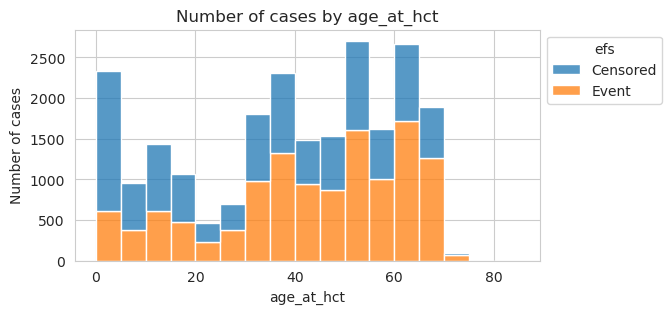

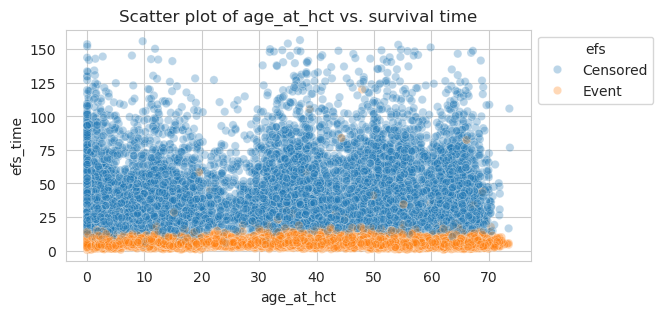

In [9]:
hist_by_efs('age_at_hct', discrete=False, bins=range(0, 90, 5))
scatter_by_efs_continuous('age_at_hct')

##### comorbidity_score

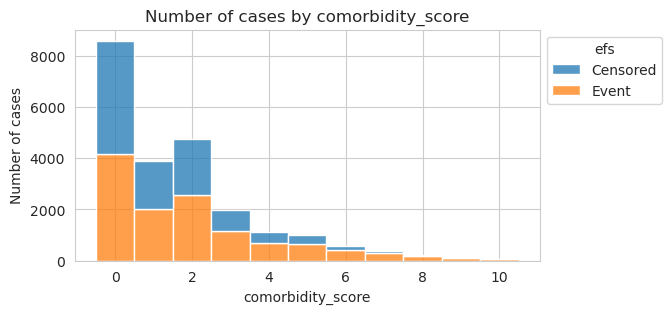

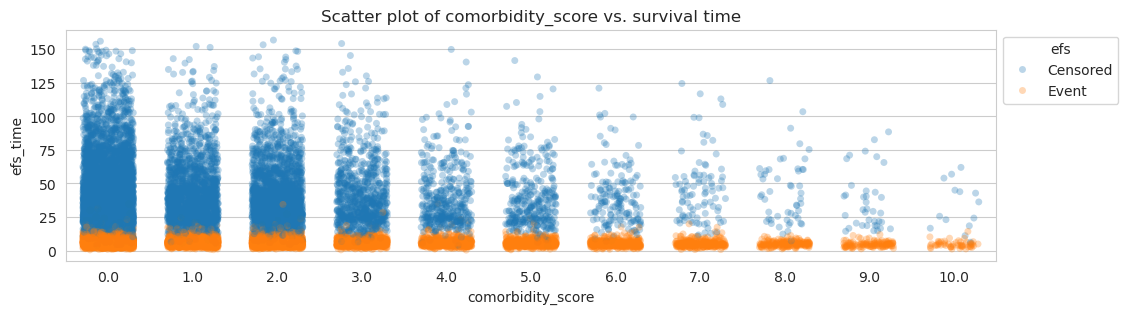

In [10]:
hist_by_efs('comorbidity_score')
scatter_by_efs_discrete('comorbidity_score')

##### karnofsky_score

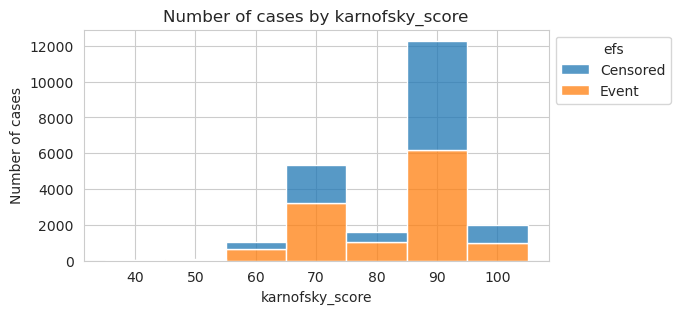

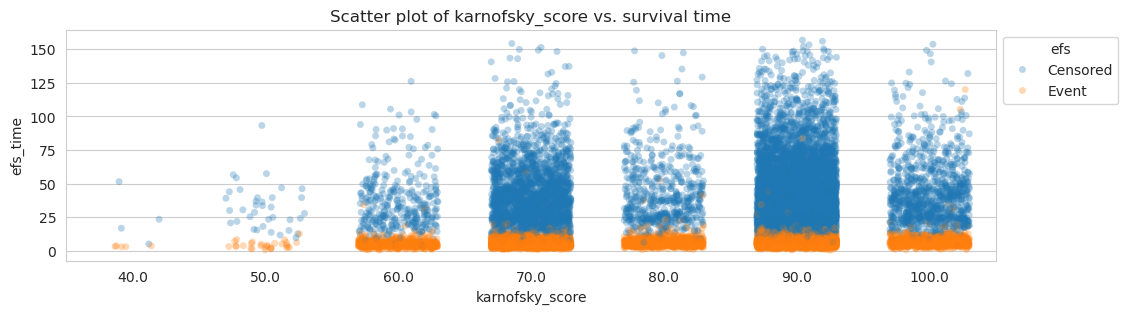

In [11]:
hist_by_efs('karnofsky_score', discrete=False, bins=range(35, 115, 10))
scatter_by_efs_discrete('karnofsky_score')

##### hla_match_drb1_high

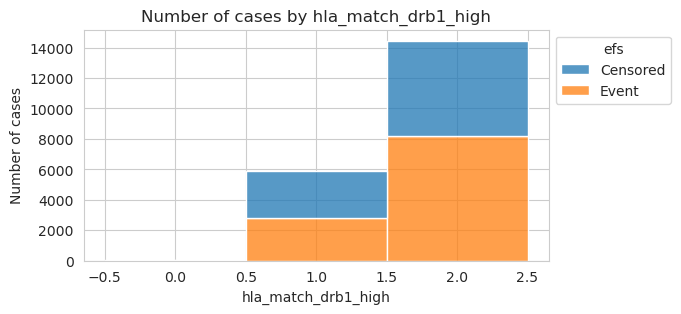

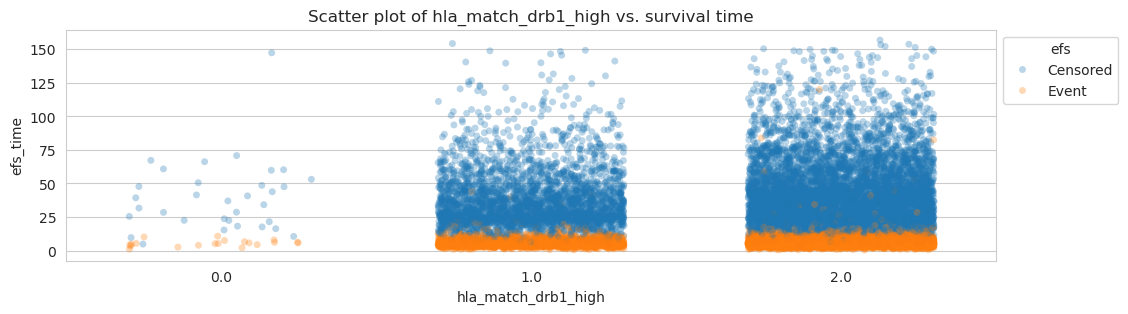

In [12]:
hist_by_efs('hla_match_drb1_high', discrete=True)
scatter_by_efs_discrete('hla_match_drb1_high')

##### hla_high_res_10

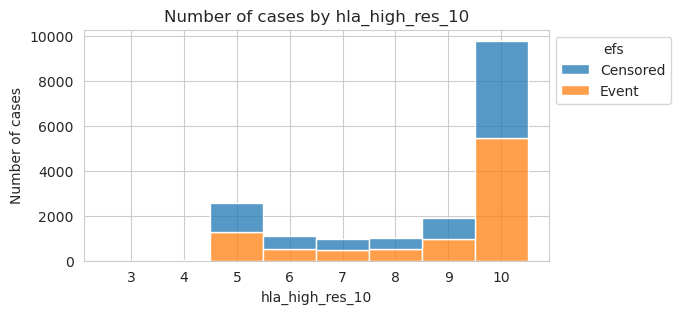

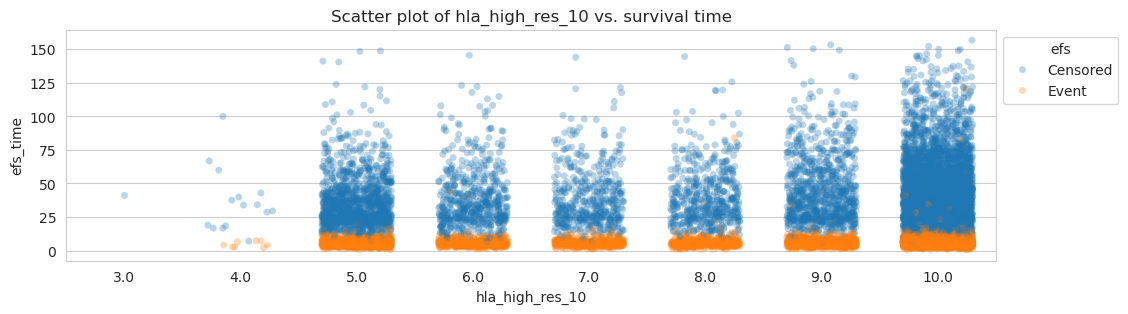

In [13]:
hist_by_efs('hla_high_res_10', discrete=True)
scatter_by_efs_discrete('hla_high_res_10')

##### race_group

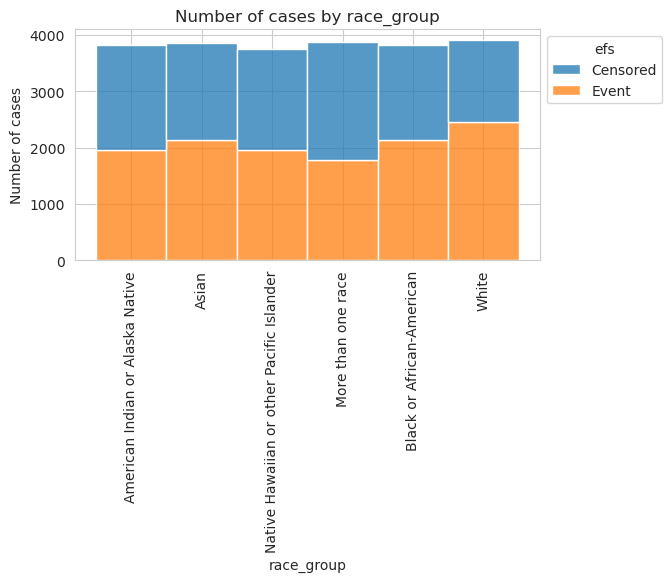

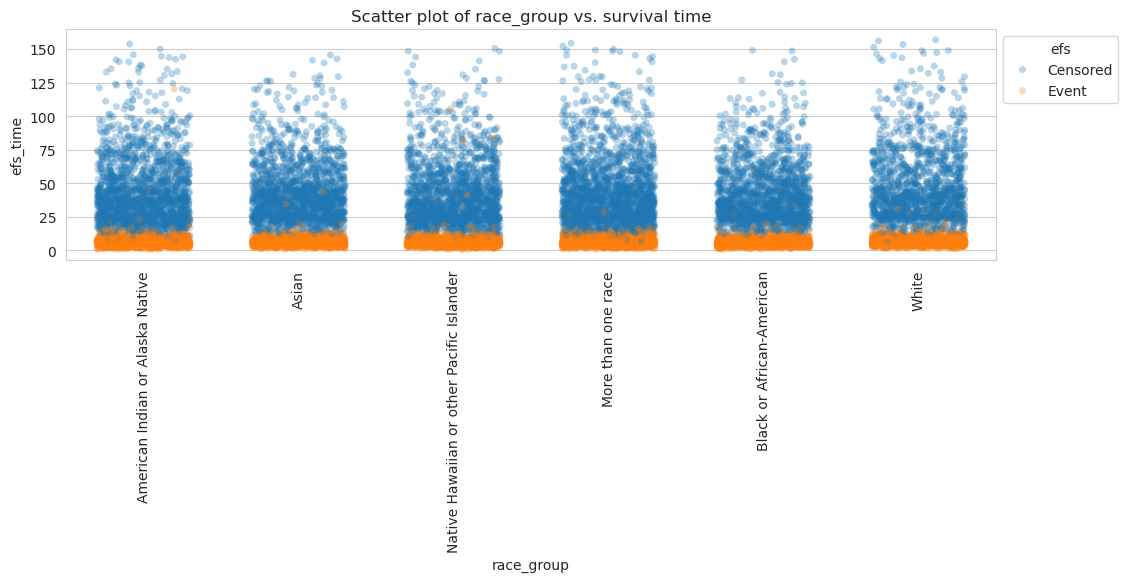

In [14]:
hist_by_efs('race_group', tick_angle=90)
scatter_by_efs_discrete('race_group', tick_angle=90)

#### Main Take-aways

- Based on these plots, it appears that younger patients have better survival outcomes. They are less likely to be recoded as `Event`, and tend to have higher survival times. Pediatric patients especially do well.
- Patients with higher comorbidity scores have worse outcomes, as expected. They are much more likely to be coded as `Event` and have lower survival times.
- Surprisingly, the plots do not show obvious trends based on HLA match or karnofsky score (a measure of day-to-day functioning). These may more informative in combination with other features, of the trends may be too subtle to be obvious on a plot.

#### Experiments with Lifelines

In this section, we use the Lifelines package to plot estimated survival functions for our study population as a whole, and for various subgroups. Please see the [Lifelines documentation](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html). We briefly summarize some key definitions.

The *survival function* for a population is given by $S(t)=Pr(T > t)$, where $T$ is a randomly-selected lifetime from the population and $t$ is time. For example, if $t$ is measured in months, and $S(12) = 0.6$ for a particular population, that means that the probability of an individual surviving at least 12 months is 60\%.

To estimate the survival function empricially we use the *Kaplan-Meier Estimate*, defined as follows. Let $t_1,\ldots,t_n$ be the times of observed events. At each time $t$, let $d_i$ be the number of events at time $t$, and let $n_i$ be the number of individuals at risk on an event just before time $t$. In other words, $n_i$ is the number of individuals which had neither experienced an event or been censored prior to time $t$. Then the Kaplan-Meier Estimate of the survival function at time $t$ is given by
$$\hat{S}(x) = \prod_{t_i < t} \frac{n_i-d_i}{d_i}$$

To test whether two grousp have different survival functions, we can use statistical tests such as the *log-rank* test.
* [Reference in the Lifeliens documentation](https://github.com/CamDavidsonPilon/lifelines/blob/master/docs/Examples.rst#statistically-compare-two-populations)
* [Wikipedia](https://en.wikipedia.org/wiki/Logrank_test)

In [15]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

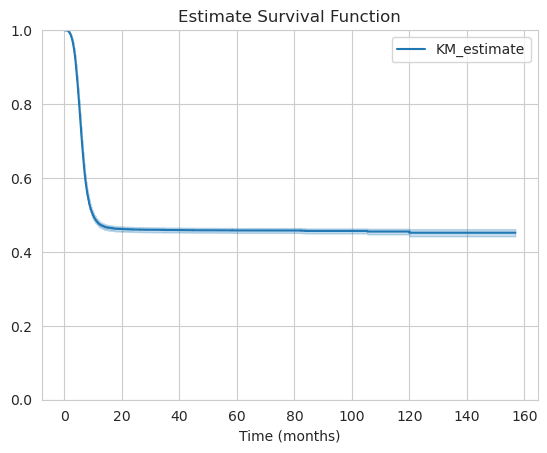

Median survival time:  9.941


In [16]:
df = pd.read_csv("../data/train_set.csv")
T = df['efs_time']
E = df['efs']
kmf.fit(T, event_observed=E)

ax = kmf.plot_survival_function()
ax.set_title("Estimate Survival Function")
ax.set_xlabel("Time (months)")
ax.set_ylim(0.0, 1.0)
plt.show()
print("Median survival time: ", kmf.median_survival_time_)

In [17]:
df.race_group.value_counts()

race_group
White                                        3905
More than one race                           3878
Asian                                        3865
American Indian or Alaska Native             3827
Black or African-American                    3821
Native Hawaiian or other Pacific Islander    3744
Name: count, dtype: int64

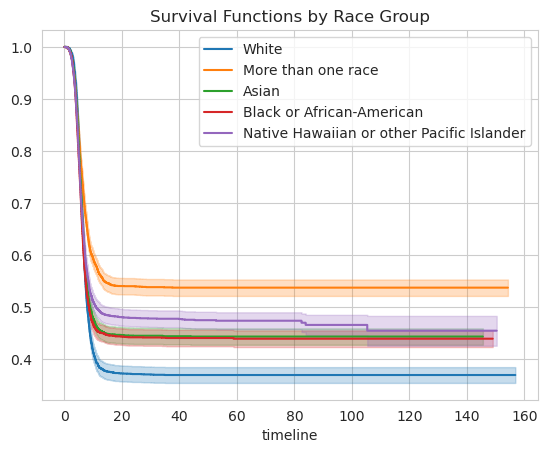

In [18]:
df_white = df[df["race_group"] == "White"]
df_multi = df[df["race_group"] == "More than one race"]
df_asian = df[df["race_group"] == "Asian"]
df_aa = df[df["race_group"] == "Black or African-American"]
df_islander = df[df["race_group"] == "Native Hawaiian or other Pacific Islander"]

ax = plt.subplot()
kmf.fit(df_white['efs_time'], event_observed=df_white["efs"], label="White")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_multi['efs_time'], event_observed=df_multi["efs"], label="More than one race")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_asian['efs_time'], event_observed=df_asian["efs"], label="Asian")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_aa['efs_time'], event_observed=df_aa["efs"], label="Black or African-American")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_islander['efs_time'], event_observed=df_islander['efs'], 
        label="Native Hawaiian or other Pacific Islander")
kmf.plot_survival_function(ax=ax)

plt.title("Survival Functions by Race Group")
plt.show()

In [19]:
#Let's see if the differences in survival functions are significant

from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test
result = multivariate_logrank_test(df["efs_time"], df["race_group"], df["efs"])
result.summary

,test_statistic,p,-log2(p)
0,211.054308,1.223793e-43,142.551549


In [20]:
def plot_by_group(feat_name, df = df, ax=None):
    if ax is None:
        ax = plt.subplot()

    vals = df[feat_name].dropna().unique()
    vals.sort()
    
    duration = df['efs_time']
    event = df['efs']

    for val in vals:
        mask = (df[feat_name] == val)
        kmf.fit(duration[mask], event[mask], label = val)
        kmf.plot_survival_function(ax=ax)

    ax.set_title("Survival functions by {}".format(feat_name))

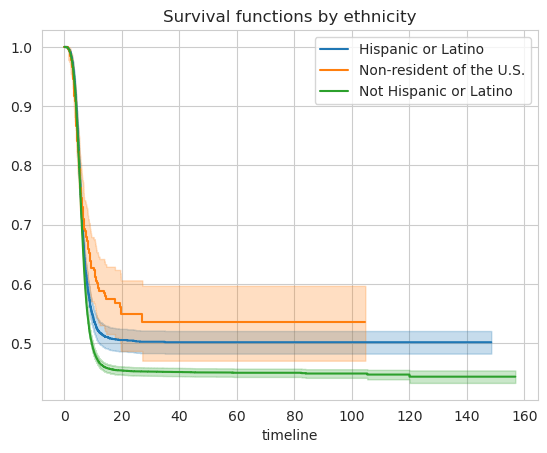

In [21]:
plot_by_group('ethnicity')

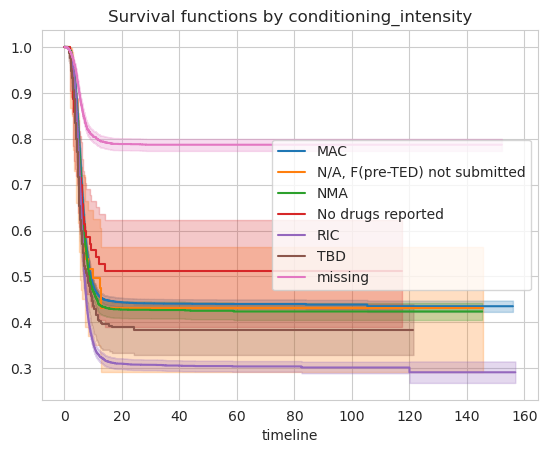

In [29]:
conditioning_df = df.copy(deep=True)
conditioning_df['conditioning_intensity'] = conditioning_df['conditioning_intensity'].fillna('missing')
plot_by_group('conditioning_intensity', df=conditioning_df)

In [30]:
conditioning_df.conditioning_intensity.value_counts()

conditioning_intensity
MAC                              9873
RIC                              6151
missing                          3784
NMA                              2812
TBD                               300
No drugs reported                  70
N/A, F(pre-TED) not submitted      50
Name: count, dtype: int64

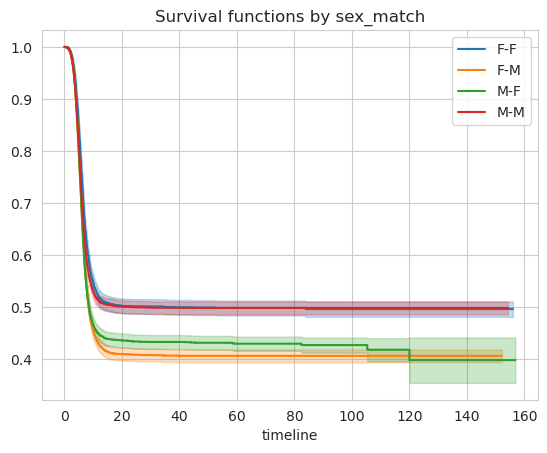

In [23]:
plot_by_group('sex_match')

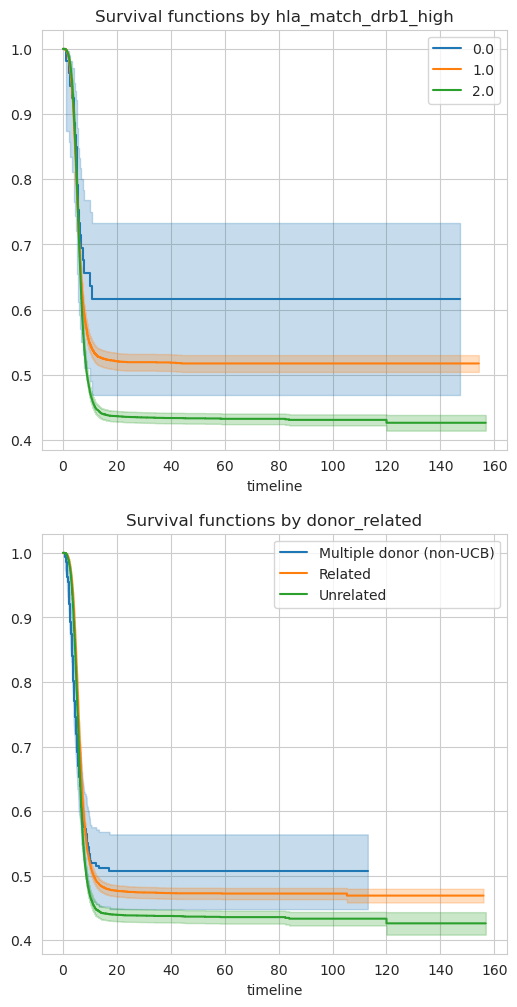

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
plot_by_group('hla_match_drb1_high', ax=ax[0])
plot_by_group('donor_related', ax=ax[1])

It is surprising that higher values of `hla_match_drb1_high` are associated with worse survival outcomes. This does not seem to agree with what the literature says about transplant outcomes. One possible explanation is that there are interactions among the variables: perhaps hla procedures with a low values of `hla_match_drb1_high` are only done in lower-risk situations. 

Based on what we know of clinical practice guidlines, it may be that allele mismatches are only allowed for related donors. As the plot above shows, having a related donor is associated with better survival outcomes.

The plot below shows that indded, related donors are much more likely to have drb1 mismatches. Related donors are also much more likely to have missing data for this feature.

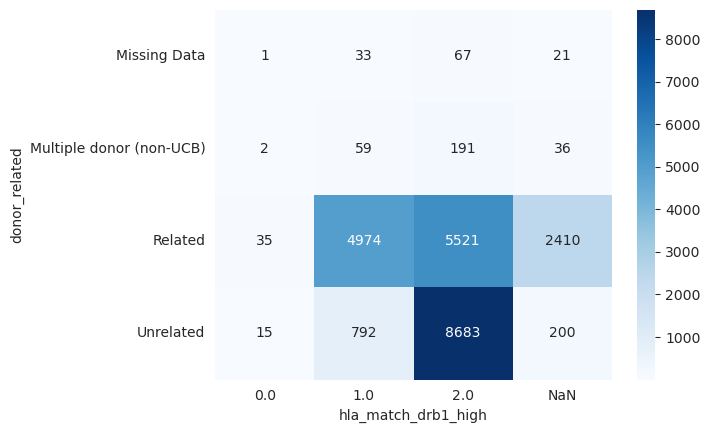

In [25]:
helper_df = df.loc[:, ['hla_match_drb1_high', 'donor_related']]
helper_df['hla_match_drb1_high'] = helper_df['hla_match_drb1_high'].astype('str').replace("nan", "NaN")
helper_df['donor_related'] = helper_df['donor_related'].fillna('Missing Data')
sns.heatmap(pd.crosstab(helper_df['donor_related'], helper_df['hla_match_drb1_high']), annot=True, fmt='d', cmap='Blues')
plt.yticks(rotation=0)
plt.show()

It's also possible that drb1 matches are related to race. Plotting crosstabs of `race_group` against drb1 match and `donor_related`, we see that white people are much more likely to have drb1 mismatches than other groups, and much more likely to have unrelated donors.

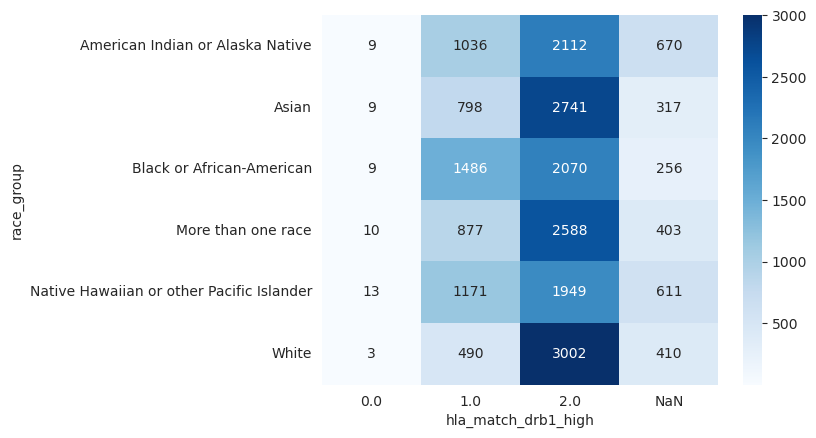

In [26]:
helper_df = df.loc[:, ['hla_match_drb1_high', 'race_group']]
helper_df['hla_match_drb1_high'] = helper_df['hla_match_drb1_high'].astype('str').replace("nan", "NaN")
helper_df['race_group'] = helper_df['race_group'].fillna('Missing Data')
sns.heatmap(pd.crosstab(helper_df['race_group'], helper_df['hla_match_drb1_high']), annot=True, fmt='d', cmap='Blues')
plt.yticks(rotation=0)
plt.show()

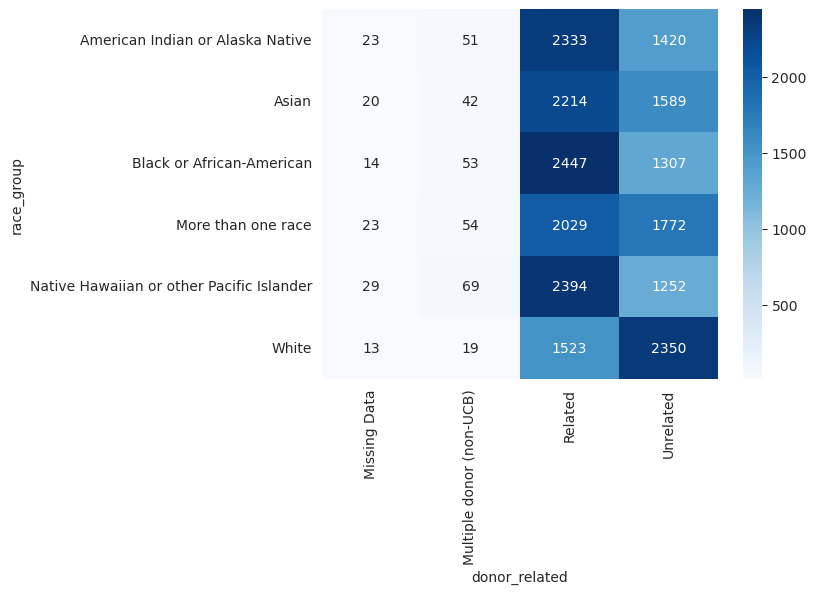

In [27]:
helper_df = df.loc[:, ['donor_related', 'race_group']].fillna('Missing Data')
sns.heatmap(pd.crosstab(helper_df['race_group'], helper_df['donor_related']), annot=True, fmt='d', cmap='Blues')
plt.yticks(rotation=0)
plt.show()